# GENERATING NECESSARY LIBRARY AND IMPORTING LIB

In [11]:
import sys
import os
from pathlib import Path
import pandas as pd

# Add the src folder to the Python path so we can import it
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Now we can import the scripts from src/
from data_cleaning import clean_data, flatten_instagram_json
from engagement_metrics import calculate_engagement_metrics, aggregate_engagement_by_month
from analysis import analyze_engagement_by_time, analyze_engagement_by_content_type
from visualize import plot_monthly_engagement, plot_engagement_rate
from enrichment import load_insights_posts, merge_posts_with_insights
from content_type_analysis import categorize_image_content
from segmentation_analysis import analyze_content_performance_by_type, segment_by_engagement
from predictive_modeling import predict_engagement
from datetime import datetime, timedelta, timezone

ROOT = Path(r"C:\Users\stefa\Documents\Codes\CarinaHardy-Instagram-Data-Analysis")

# Data cleaning and processing

In [2]:
posts_file = list(ROOT.rglob("your_instagram_activity/media/posts_1.json"))
assert posts_file, "Couldn't find posts JSON. Check your path."
posts_df_raw = flatten_instagram_json(posts_file[0])

posts_df = clean_data(posts_df_raw)
posts_df.head()   

c:\Users\stefa\Documents\Codes\CarinaHardy-Instagram-Data-Analysis\insta-Project\src\data_cleaning.py:108: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["creation_month"] = df["creation_timestamp"].dt.to_period("M")


,uri,creation_timestamp,title,top_creation_timestamp,top_title,dubbing_info,media_variants,product_tags,media_metadata.camera_metadata.has_camera_metadata,cross_post_source.source_app,creation_date,creation_month,top_creation_date
0,media/other/18005202119701873.jpg,2024-12-30 21:00:47+07:00,Cousin Itt.,NaT,,NaN,NaN,NaN,False,FB,2024-12-30,2024-12,NaT
1,media/other/18067352005700577.jpg,2024-12-28 21:01:00+07:00,10/100 does not equal 1/10.,NaT,,NaN,NaN,NaN,False,FB,2024-12-28,2024-12,NaT
2,media/other/18045234064965601.jpg,2024-12-26 20:00:44+07:00,An old sport.,NaT,,NaN,NaN,NaN,False,FB,2024-12-26,2024-12,NaT
3,media/posts/202412/18021149483636820.jpg,2024-12-25 10:00:39+07:00,,2024-12-25 10:00:39+07:00,Oh itâs Christmas.,NaN,NaN,NaN,False,FB,2024-12-25,2024-12,2024-12-25
4,media/posts/202412/18108260365453441.jpg,2024-12-25 10:00:39+07:00,,2024-12-25 10:00:39+07:00,Oh itâs Christmas.,NaN,NaN,NaN,False,FB,2024-12-25,2024-12,2024-12-25


In [6]:
insights_df = load_insights_posts(ROOT)
insights_df.head()


,uri,creation_timestamp,title,likes,comments,reach,impressions,saves,shares,profile_visits,follows
0,media/other/18005202119701873.jpg,1735567247,Cousin Itt.,42,0,926,1047,5,2,4,0
1,media/other/18067352005700577.jpg,1735394460,10/100 does not equal 1/10.,37,0,1016,1108,2,1,7,1
2,media/other/18045234064965601.jpg,1735218044,An old sport.,26,0,639,698,2,0,5,0
3,media/other/17850460545325482.jpg,1735052452,Controlling the view.,57,0,1154,1266,2,0,16,0
4,media/other/18365546479137722.jpg,1734966056,What a do.,47,1,737,805,2,1,7,0


In [7]:
insights_df.dtypes


uri                   object
creation_timestamp     int64
title                 object
likes                  int64
comments               int64
reach                  int64
impressions            int64
saves                  int64
shares                 int64
profile_visits         int64
follows                int64
dtype: object

In [8]:
insights_df.shape

(205, 11)

In [9]:
posts_file = list(ROOT.rglob("your_instagram_activity/media/posts_1.json"))[0]
posts_df = clean_data(flatten_instagram_json(posts_file))

c:\Users\stefa\Documents\Codes\CarinaHardy-Instagram-Data-Analysis\insta-Project\src\data_cleaning.py:108: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["creation_month"] = df["creation_timestamp"].dt.to_period("M")


In [12]:
# Asia/Jakarta timezone
LOCAL_TZ = timezone(timedelta(hours=7))

# Convert if it's numeric
if insights_df["creation_timestamp"].dtype != "datetime64[ns, UTC+07:00]":
    insights_df["creation_timestamp"] = pd.to_datetime(
        insights_df["creation_timestamp"], unit="s", utc=True
    ).dt.tz_convert(LOCAL_TZ)


In [24]:
# merge
posts_enriched = posts_df.merge(
    insights_df,
    how="left",
    on=["uri","creation_timestamp","title"],  # best-case match
)
# Fallback: fill NaNs
for c in ["likes","comments","reach","impressions","saves","shares"]:
    if c not in posts_enriched.columns:
        posts_enriched[c] = 0
    posts_enriched[c] = pd.to_numeric(posts_enriched[c], errors="coerce").fillna(0)

# metrics
posts_enriched = calculate_engagement_metrics(posts_enriched)
posts_enriched
posts_enriched.to_csv(r"C:\Users\stefa\Documents\Codes\CarinaHardy-Instagram-Data-Analysis\insta-Project\data\source_data\processed\posts_enriched.csv", index=False)

# Analysis starts from here

C:\Users\stefa\AppData\Local\Temp\ipykernel_5072\1202712746.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly["month"] = monthly["creation_timestamp"].dt.to_period("M")


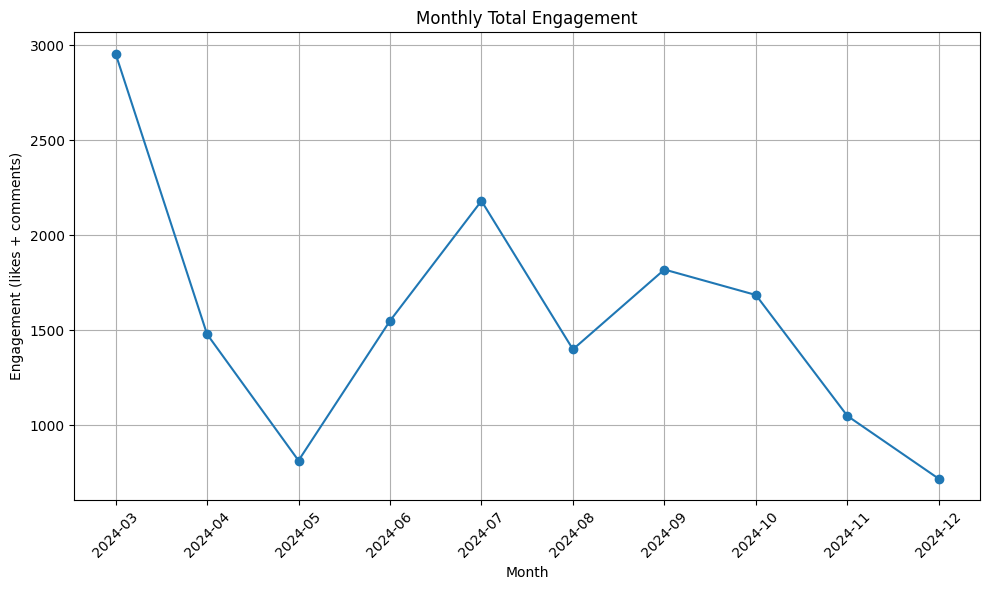

In [14]:
import matplotlib.pyplot as plt

# Aggregate engagement metrics by month
monthly = posts_enriched.copy()
monthly["month"] = monthly["creation_timestamp"].dt.to_period("M")
monthly = (
    monthly.groupby("month")[["likes", "comments", "reach", "impressions", "engagement"]]
    .sum()
    .reset_index()
)
monthly["month"] = monthly["month"].astype(str)

plt.figure(figsize=(10, 6))
plt.plot(monthly["month"], monthly["engagement"], marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Total Engagement")
plt.xlabel("Month")
plt.ylabel("Engagement (likes + comments)")
plt.grid(True)
plt.tight_layout()
plt.show()


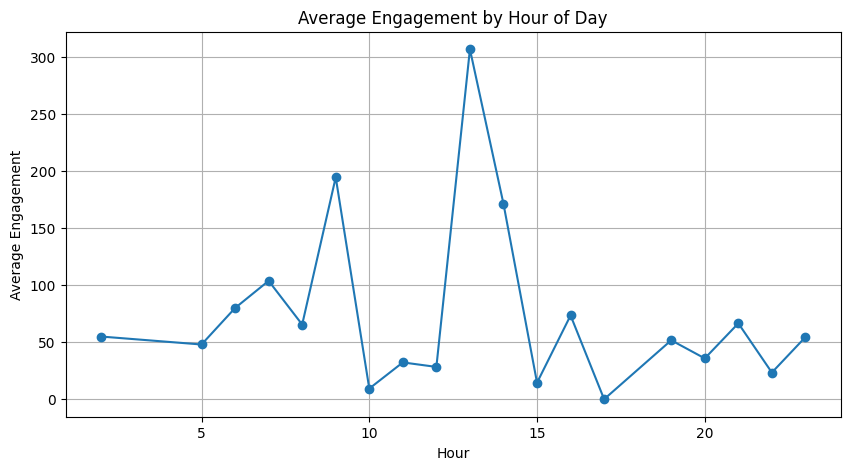

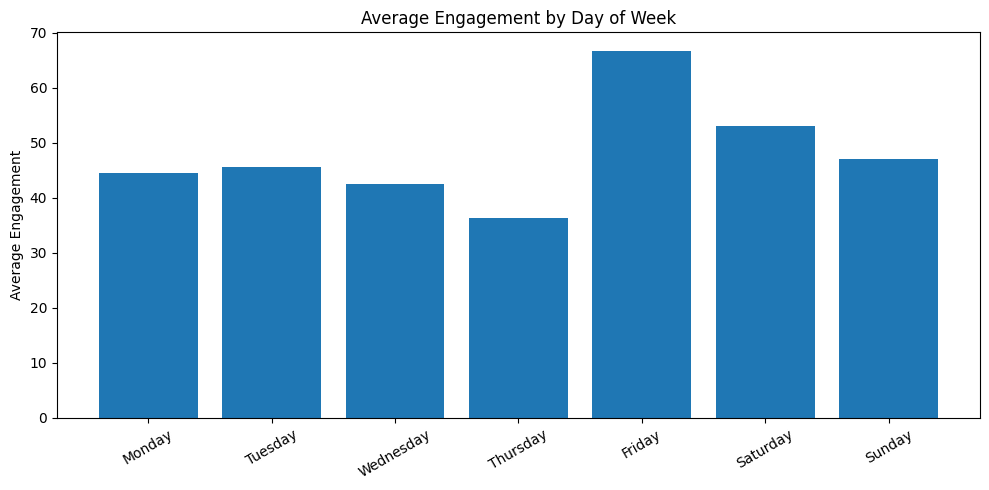

In [15]:
# Extract hour and weekday
posts_enriched["hour"] = posts_enriched["creation_timestamp"].dt.hour
posts_enriched["weekday"] = posts_enriched["creation_timestamp"].dt.day_name()

# Average engagement per hour
hourly = posts_enriched.groupby("hour")["engagement"].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(hourly["hour"], hourly["engagement"], marker="o")
plt.title("Average Engagement by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Engagement")
plt.grid(True)
plt.show()

# Average engagement per weekday
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday = (
    posts_enriched.groupby("weekday")["engagement"]
    .mean()
    .reindex(weekday_order)
    .reset_index()
)

plt.figure(figsize=(10, 5))
plt.bar(weekday["weekday"], weekday["engagement"])
plt.title("Average Engagement by Day of Week")
plt.xticks(rotation=30)
plt.ylabel("Average Engagement")
plt.tight_layout()
plt.show()


In [16]:
posts_enriched["like_rate"] = (posts_enriched["likes"] / posts_enriched["reach"]).replace([float("inf"), -float("inf")], 0)
posts_enriched["comment_rate"] = (posts_enriched["comments"] / posts_enriched["reach"]).replace([float("inf"), -float("inf")], 0)
posts_enriched["save_rate"] = (posts_enriched["saves"] / posts_enriched["reach"]).replace([float("inf"), -float("inf")], 0)

efficiency = posts_enriched[["title", "reach", "likes", "comments", "saves", "like_rate", "comment_rate", "save_rate"]]
efficiency.sort_values(by="like_rate", ascending=False).head(10)


,title,reach,likes,comments,saves,like_rate,comment_rate,save_rate
87,Namesake.,1410.0,167.0,9.0,1.0,0.118440,0.006383,0.000709
205,Motion in stillness.,2648.0,312.0,6.0,35.0,0.117825,0.002266,0.013218
123,Playing dress down.,1815.0,202.0,7.0,5.0,0.111295,0.003857,0.002755
107,Devotional rapture.,2921.0,302.0,5.0,29.0,0.103389,0.001712,0.009928
183,"____, can I post this?",2670.0,274.0,7.0,24.0,0.102622,0.002622,0.008989
103,"Carina, Carina â¦ â¦. â¦. â¦.",1588.0,157.0,7.0,6.0,0.098866,0.004408,0.003778
79,Everything we do is in the name of love.,2570.0,254.0,18.0,6.0,0.098833,0.007004,0.002335
135,Cannon balls.,2038.0,200.0,7.0,11.0,0.098135,0.003435,0.005397
288,Venus surrounded by eggs.,840.0,81.0,1.0,2.0,0.096429,0.001190,0.002381
96,Teasing perception.,990.0,93.0,2.0,6.0,0.093939,0.002020,0.006061


In [17]:
top_posts = posts_enriched.sort_values(by="engagement_rate", ascending=False).head(10)
top_posts[["title", "likes", "comments", "reach", "impressions", "engagement_rate"]]


,title,likes,comments,reach,impressions,engagement_rate
181,Topography of a tango.,464.0,4.0,22855.0,32764.0,0.468
318,Bite test. Tastes recycled.,426.0,18.0,27530.0,48572.0,0.444
213,99 out of a 100 donât make it.,381.0,22.0,25455.0,42099.0,0.403
182,The Chosen One.,312.0,11.0,16793.0,31709.0,0.323
205,Motion in stillness.,312.0,6.0,2648.0,3024.0,0.318
107,Devotional rapture.,302.0,5.0,2921.0,3156.0,0.307
313,Hold on. \nHere we go.,287.0,18.0,15546.0,26749.0,0.305
295,Accent curves and colors.,287.0,6.0,3250.0,3706.0,0.293
183,"____, can I post this?",274.0,7.0,2670.0,3028.0,0.281
79,Everything we do is in the name of love.,254.0,18.0,2570.0,2848.0,0.272


In [18]:
def label_performance(rate):
    if rate >= posts_enriched["engagement_rate"].quantile(0.75):
        return "Quantile 0.75"
    elif rate >= posts_enriched["engagement_rate"].quantile(0.25):
        return "Quantile 0.25"
    else:
        return "Low"

posts_enriched["performance_label"] = posts_enriched["engagement_rate"].apply(label_performance)
posts_enriched["performance_label"].value_counts()


performance_label
Quantile 0.25    236
Quantile 0.75     83
Name: count, dtype: int64

# Content Type Analysis

In [19]:
from content_type_analysis import categorize_image_content

# Classify images in posts_df based on their content attributes
posts_df = categorize_image_content(posts_df)

# Check how many posts fall into each category
posts_df['aspect_ratio'].value_counts()

# You can also inspect 'contains_people' and 'contains_jewelry'
posts_df[['contains_people', 'contains_jewelry']].head()


KeyError: 'width'

In [ ]:
from segmentation_analysis import analyze_content_performance_by_type

# Analyze content performance based on content type
analyze_content_performance_by_type(posts_df)
segment_by_engagement(posts_df)

In [ ]:
from predictive_modeling import predict_engagement

predict_engagement(posts_df)
